<a href="https://www.kaggle.com/code/ravaghi/wsdm-cup-gemma-2-9b-logistic-regression?scriptVersionId=220753584" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

- Training notebook: https://www.kaggle.com/code/ravaghi/wsdm-cup-autogluon-training?scriptVersionId=220752804

# Imports and configs

In [1]:
from transformers import Gemma2ForSequenceClassification, GemmaTokenizerFast
from transformers.data.data_collator import pad_without_fast_tokenizer_warning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from concurrent.futures import ThreadPoolExecutor
from timeit import default_timer as timer
from peft import PeftModel
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from scipy.special import logit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import optuna
import torch
import json
import gc
import os

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/wsdm-cup-multilingual-chatbot-arena/train.parquet'
    test_path = '/kaggle/input/wsdm-cup-multilingual-chatbot-arena/test.parquet'
    sample_sub_path = '/kaggle/input/wsdm-cup-multilingual-chatbot-arena/sample_submission.csv'

    data_path = '/kaggle/input/wsdm-cup-gemma-2-9b-4-bit-qlora'

    gemma_dir = "/kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old"
    lora_dir = "/kaggle/input/wsdm-cup-gemma-2-9b-4-bit-qlora/gemma2-9b-4bit/fold-0/gemma-2-9b-it-bnb-4bit-3072-8-f0/checkpoint-2900"
    
    max_length = 3072
    batch_size = 4

    target = 'winner'
    n_folds = 5
    seed = 42

    char_vectorizer_params = {
        'analyzer': "char",
        "lowercase": False,
        "max_df": 0.605,
        "max_features": 331,
        "min_df": 0.075,
        "ngram_range": (1, 3),
        "strip_accents": "unicode"
    }

    word_vectorizer_params = {
        "analyzer": "word",
        "lowercase": True,
        "max_df": 0.985,
        "max_features": 769,
        "min_df": 0.01,
        "ngram_range": (1, 2),
        "strip_accents": "unicode"
    }

# Gemma-2 9b 4-bit

In [3]:
test = pd.read_parquet(CFG.test_path).fillna('')

In [4]:
if len(test) > 10_000:
    time_limit = int(3600 * 12) 
else:
    time_limit = int(3600 * 4.75)

## Tokenizing

In [5]:
def tokenize(tokenizer, prompt, response_a, response_b, max_length=CFG.max_length):
    prompt = ["<prompt>: " + t for t in prompt]
    response_a = ["\n\n<response_a>: " + t for t in response_a]
    response_b = ["\n\n<response_b>: " + t for t in response_b]
    
    texts = [p + r_a + r_b for p, r_a, r_b in zip(prompt, response_a, response_b)]
    tokenized = tokenizer(texts, max_length=max_length, truncation=True)
    
    return tokenized['input_ids'], tokenized['attention_mask']

In [6]:
tokenizer = GemmaTokenizerFast.from_pretrained(CFG.gemma_dir)
tokenizer.add_eos_token = True
tokenizer.padding_side = "right"

In [7]:
for col in ['prompt', 'response_a', 'response_b']:
    test[col] = test[col].fillna('')
    text_list = []
    if col == "prompt":
        max_no = 512
        s_no = 255
        e_no = -256
    else:
        max_no = 3072
        s_no = 1535
        e_no = -1536
    for text in tqdm(test[col]):
        encoded = tokenizer(text, return_offsets_mapping=True)
        if len(encoded['input_ids']) > max_no:
            start_idx, end_idx = encoded['offset_mapping'][s_no]
            new_text = text[:end_idx]
            start_idx, end_idx = encoded['offset_mapping'][e_no]
            new_text = new_text + "\n(snip)\n" + text[start_idx:]
            text = new_text
        text_list.append(text)
    test[col] = text_list

100%|██████████| 3/3 [00:00<00:00, 720.18it/s]


In [8]:
data = pd.DataFrame()
data["id"] = test["id"]
data["input_ids"], data["attention_mask"] = tokenize(tokenizer, test["prompt"], test["response_a"], test["response_b"])
data["length"] = data["input_ids"].apply(len)

aug_data = pd.DataFrame()
aug_data["id"] = test["id"]
# swap response_a & response_b
aug_data['input_ids'], aug_data['attention_mask'] = tokenize(tokenizer, test["prompt"], test["response_b"], test["response_a"])
aug_data["length"] = aug_data["input_ids"].apply(len)

## Model

In [9]:
model_0 = Gemma2ForSequenceClassification.from_pretrained(
    CFG.gemma_dir,
    device_map=torch.device("cuda:0"),
    use_cache=False,
)

model_1 = Gemma2ForSequenceClassification.from_pretrained(
    CFG.gemma_dir,
    device_map=torch.device("cuda:1"),
    use_cache=False,
)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for p

In [10]:
model_0 = PeftModel.from_pretrained(model_0, CFG.lora_dir)
model_1 = PeftModel.from_pretrained(model_1, CFG.lora_dir)

In [11]:
model_0.eval()
model_1.eval()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Gemma2ForSequenceClassification(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 3584, padding_idx=0)
        (layers): ModuleList(
          (0-15): 16 x Gemma2DecoderLayer(
            (self_attn): Gemma2SdpaAttention(
              (q_proj): Linear4bit(in_features=3584, out_features=4096, bias=False)
              (k_proj): Linear4bit(in_features=3584, out_features=2048, bias=False)
              (v_proj): Linear4bit(in_features=3584, out_features=2048, bias=False)
              (o_proj): Linear4bit(in_features=4096, out_features=3584, bias=False)
              (rotary_emb): Gemma2RotaryEmbedding()
            )
            (mlp): Gemma2MLP(
              (gate_proj): Linear4bit(in_features=3584, out_features=14336, bias=False)
              (up_proj): Linear4bit(in_features=3584, out_features=14336, bias=False)
              (down_proj): Linear4bit(in_features=14336, out_features=3584,

## Inference

In [12]:
@torch.no_grad()
@torch.cuda.amp.autocast()
def inference(df, model, device, batch_size, max_length=CFG.max_length):
    winners = []
    
    for start_idx in range(0, len(df), batch_size):
        end_idx = min(start_idx + batch_size, len(df))
        tmp = df.iloc[start_idx:end_idx]
        input_ids = tmp["input_ids"].to_list()
        attention_mask = tmp["attention_mask"].to_list()
        inputs = pad_without_fast_tokenizer_warning(
            tokenizer,
            {"input_ids": input_ids, "attention_mask": attention_mask},
            padding="longest",
            pad_to_multiple_of=None,
            return_tensors="pt",
        )
        outputs = model(**inputs.to(device))
        proba = outputs.logits.softmax(-1).cpu()
        
        winners.extend(proba[:, 1].tolist())
    
    df['winner'] = winners
    
    return df

In [13]:
global_timer = timer()

In [14]:
data['index'] = np.arange(len(data), dtype=np.int32)
data = data.sort_values("length", ascending=False)

In [15]:
data_dict = {}
data_dict[0] = data[data["length"] > 1024].reset_index(drop=True)
data_dict[1] = data[data["length"] <= 1024].reset_index(drop=True)

In [16]:
result_df = []
for i, batch_size in enumerate([CFG.batch_size, CFG.batch_size]):
    if len(data_dict[i]) == 0:
        continue
        
    sub_1 = data_dict[i].iloc[0::2].copy()
    sub_2 = data_dict[i].iloc[1::2].copy()
    
    with ThreadPoolExecutor(max_workers=2) as executor:
        results = executor.map(
            inference, 
            (sub_1, sub_2), 
            (model_0, model_1), 
            (torch.device("cuda:0"), torch.device("cuda:1")), 
            (batch_size, batch_size)
        )
        
    result_df.append(pd.concat(list(results), axis=0))

In [17]:
result_df = pd.concat(result_df).sort_values('index').reset_index(drop=True)

In [18]:
aug_data['index'] = np.arange(len(aug_data), dtype=np.int32)
aug_data = aug_data.sort_values("length", ascending=False)

In [19]:
CONFIDENCE_THRESHOLD = 0.2
not_confident_mask = abs(result_df['winner'] - 0.5) < CONFIDENCE_THRESHOLD

aug_data = aug_data[aug_data['index'].isin(result_df[not_confident_mask]['index'])]

In [20]:
aug_data_dict = {}
aug_data_dict[0] = aug_data[aug_data["length"] > 1024].reset_index(drop=True)
aug_data_dict[1] = aug_data[aug_data["length"] <= 1024].reset_index(drop=True)

In [21]:
aug_result_df = []
for i, batch_size in enumerate([CFG.batch_size, CFG.batch_size]):
    if len(aug_data_dict[i]) == 0:
        continue

    if timer() - global_timer > (time_limit - 900):
        break
        
    sub_1 = aug_data_dict[i].iloc[0::2].copy()
    sub_2 = aug_data_dict[i].iloc[1::2].copy()
    
    with ThreadPoolExecutor(max_workers=2) as executor:
        results = executor.map(
            inference, 
            (sub_1, sub_2), 
            (model_0, model_1), 
            (torch.device("cuda:0"), torch.device("cuda:1")), 
            (batch_size, batch_size)
        )
        
    aug_result_df.append(pd.concat(list(results), axis=0))

In [22]:
if len(aug_result_df) > 0:
    aug_result_df = pd.concat(aug_result_df).sort_values('index').reset_index(drop=True)
    aug_result_df["winner"] = 1 - aug_result_df['winner']
    
    result_df = result_df.merge(
        aug_result_df[['index', 'winner']], 
        on='index', 
        how='left', 
        suffixes=('', '_aug')
    )
    
    mask = result_df['winner_aug'].notna()
    result_df.loc[mask, 'winner'] = (result_df.loc[mask, 'winner'] + result_df.loc[mask, 'winner_aug']) / 2
    
    result_df = result_df.drop('winner_aug', axis=1)

# Tabular models

In [23]:
gemma_test_pred_probs = result_df['winner'].values

## Loading and processing data

In [24]:
def reduce_mem_usage(dataframe):
    print('--- Reducing memory usage')
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        if col_type.name in ['category', 'object']:
            continue

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('------ Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('------ Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('------ Decreased memory usage by {:.1f}%'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [25]:
def add_word_features(df, column):
    # Basic word counts
    df[f'{column}_word_count'] = df[column].apply(lambda x: len(x.split()))
    df[f'{column}_unique_word_count'] = df[column].apply(lambda x: len(set(x.lower().split())))
    
    # Word length statistics
    def safe_word_stats(text):
        words = str(text).split()
        if not words:
            return 0, 0  # avg_length, max_length for empty text
        word_lengths = [len(word) for word in words]
        return np.mean(word_lengths), max(word_lengths)
    
    word_stats = df[column].apply(safe_word_stats)
    df[f'{column}_avg_word_length'] = word_stats.apply(lambda x: x[0])
    df[f'{column}_max_word_length'] = word_stats.apply(lambda x: x[1])
    
    # Lexical diversity (unique words / total words)
    df[f'{column}_lexical_diversity'] = df.apply(
        lambda x: x[f'{column}_unique_word_count'] / x[f'{column}_word_count'] 
        if x[f'{column}_word_count'] > 0 else 0, axis=1
    )
    
    # Count specific word types
    df[f'{column}_uppercase_word_count'] = df[column].apply(lambda x: sum(1 for word in x.split() if word.isupper()))
    df[f'{column}_title_case_word_count'] = df[column].apply(lambda x: sum(1 for word in x.split() if word.istitle()))
    
    return df

def add_char_features(df, column):
    # Basic character counts
    df[f'{column}_char_count'] = df[column].str.len()
    df[f'{column}_letter_count'] = df[column].apply(lambda x: sum(c.isalpha() for c in x))
    df[f'{column}_digit_count'] = df[column].apply(lambda x: sum(c.isdigit() for c in x))
    df[f'{column}_whitespace_count'] = df[column].apply(lambda x: sum(c.isspace() for c in x))
    
    # Punctuation counts
    df[f'{column}_punctuation_count'] = df[column].apply(lambda x: sum(c in '.,!?;:' for c in x))
    df[f'{column}_special_char_count'] = df[column].apply(lambda x: sum(not (c.isalnum() or c.isspace()) for c in x))
    
    # Character ratios with safe division
    df[f'{column}_uppercase_ratio'] = df[column].apply(lambda x: sum(c.isupper() for c in x) / max(len(x), 1))
    df[f'{column}_lowercase_ratio'] = df[column].apply(lambda x: sum(c.islower() for c in x) / max(len(x), 1))
    
    return df

def add_sentence_features(df, column):
    # Sentence counts
    df[f'{column}_sentence_count'] = df[column].apply(lambda x: len(sent_tokenize(x)))
    
    # Average sentence length with safe division
    df[f'{column}_avg_sentence_length'] = df[column].apply(
        lambda x: np.mean([len(sent.split()) for sent in sent_tokenize(x)])
        if len(sent_tokenize(x)) > 0 else 0
    )
    
    # Sentence length variation with safe handling
    df[f'{column}_sentence_length_std'] = df[column].apply(
        lambda x: np.std([len(sent.split()) for sent in sent_tokenize(x)]) 
        if len(sent_tokenize(x)) > 1 else 0
    )
    
    # Question and exclamation counts
    df[f'{column}_question_count'] = df[column].str.count('\?')
    df[f'{column}_exclamation_count'] = df[column].str.count('!')
    
    return df

def add_stats_features(df, column):
    # Readability metrics (simplified Flesch Reading Ease)
    def calculate_readability(text):
        sentences = sent_tokenize(text)
        words = text.split()
        if not words or not sentences:
            return 0
        avg_sentence_length = len(words) / len(sentences)
        avg_syllables_per_word = sum(count_syllables(word) for word in words) / len(words)
        return 206.835 - (1.015 * avg_sentence_length) - (84.6 * avg_syllables_per_word)
    
    def count_syllables(word):
        word = word.lower()
        count = 0
        vowels = 'aeiouy'
        if word[0] in vowels:
            count += 1
        for index in range(1, len(word)):
            if word[index] in vowels and word[index-1] not in vowels:
                count += 1
        if word.endswith('e'):
            count -= 1
        if count == 0:
            count = 1
        return count
    
    df[f'{column}_readability_score'] = df[column].apply(calculate_readability)
    
    # Text complexity features with safe division
    df[f'{column}_avg_word_per_sentence'] = df.apply(
        lambda x: x[f'{column}_word_count'] / x[f'{column}_sentence_count']
        if x[f'{column}_sentence_count'] > 0 else 0, axis=1
    )
    
    df[f'{column}_char_per_word'] = df.apply(
        lambda x: x[f'{column}_char_count'] / x[f'{column}_word_count']
        if x[f'{column}_word_count'] > 0 else 0, axis=1
    )
    
    return df

def get_text_similarity(text1, text2):
    text1, text2 = str(text1), str(text2)
    
    chars1, chars2 = set(text1.lower()), set(text2.lower())
    char_similarity = len(chars1 & chars2) / max(len(chars1 | chars2), 1)
    
    words1 = set(text1.lower().split())
    words2 = set(text2.lower().split())
    word_similarity = len(words1 & words2) / max(len(words1 | words2), 1)
    
    length_ratio = len(text1) / max(len(text2), 1)
    
    return char_similarity, word_similarity, length_ratio

def add_features(df, is_train):
    if is_train:
        features = joblib.load(f'{CFG.data_path}/features/train_features.pkl')
        df = df.merge(features, on='id', how='left')
        return df
    
    for column in ['prompt', 'response_a', 'response_b']:
        df = add_word_features(df, column)
        df = add_char_features(df, column)
        df = add_sentence_features(df, column)
        df = add_stats_features(df, column)
        
    # Add text similarity features between prompt and response_a/response_b
    similarities_a = df.apply(lambda row: get_text_similarity(row['prompt'], row['response_a']), axis=1)
    similarities_b = df.apply(lambda row: get_text_similarity(row['prompt'], row['response_b']), axis=1)
    df['prompt_response_a_char_sim'], df['prompt_response_a_word_sim'], df['prompt_response_a_length_ratio'] = zip(*similarities_a)
    df['prompt_response_b_char_sim'], df['prompt_response_b_word_sim'], df['prompt_response_b_length_ratio'] = zip(*similarities_b)
        
    # Add comparative features between response_a and response_b with safe division
    for feature in df.columns:
        if feature.startswith('response_a_'):
            corresponding_b = feature.replace('response_a_', 'response_b_')
            if corresponding_b in df.columns:
                df[f'diff_{feature.replace("response_a_", "")}'] = df[feature] - df[corresponding_b]
                df[f'ratio_{feature.replace("response_a_", "")}'] = df.apply(
                    lambda x: x[feature] / x[corresponding_b] 
                    if x[corresponding_b] != 0 else 0, axis=1
                )
    
    return df

In [26]:
def add_tfidf_features(df, is_train):
    if is_train:
        tfidf_features = joblib.load(f'{CFG.data_path}/features/train_tfidf_features.pkl')
        df = df.merge(tfidf_features, on='id', how='left')
        return df

    for column in ['prompt', 'response_a', 'response_b']:
        for params in [CFG.char_vectorizer_params, CFG.word_vectorizer_params]:
            
            tfidf_vectorizer = joblib.load(f'{CFG.data_path}/vectorizers/{column}_{params["analyzer"]}_tfidf_vectorizer.pkl')
            tfidf_matrix = tfidf_vectorizer.transform(df[column].fillna(''))
            tfidf_dense = tfidf_matrix.toarray()
            
            feature_names = tfidf_vectorizer.get_feature_names_out()
            for i in range(len(feature_names)):
                df[f'{column}_{params["analyzer"]}_tfidf_{i}'] = tfidf_dense[:, i]
            
            del tfidf_vectorizer, tfidf_matrix, tfidf_dense
            
            gc.collect()
            
    return df

In [27]:
train = pd.read_parquet(CFG.train_path)
test = pd.read_parquet(CFG.test_path)

train[CFG.target] = train[CFG.target].map({"model_a": 0, "model_b": 1})

train = train.drop(columns=['model_a', 'model_b', 'language'])
test = test.drop(columns=['scored'])

In [28]:
train = add_features(train, is_train=True)
test = add_features(test, is_train=False)

In [29]:
train = add_tfidf_features(train, is_train=True)
test = add_tfidf_features(test, is_train=False)

In [30]:
train['tta_oof'] = joblib.load(f'{CFG.data_path}/features/tta_oof_pred_probs_acc_0.683437.pkl')
test['tta_oof'] = gemma_test_pred_probs

In [31]:
X = train.drop(columns=[CFG.target, 'id', 'prompt', 'response_a', 'response_b'])
y = train[CFG.target]

X_test = test.drop(columns=['id', 'prompt', 'response_a', 'response_b'])

In [32]:
X.shape, X_test.shape

((48439, 3370), (3, 3370))

## Training base models

In [33]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit(self, X, y):
        model_name = self.model.__class__.__name__.lower()
        print(f'Training {model_name}\n')
        
        scores = []        
        models = []
        oof_pred_probs = np.zeros(X.shape[0])
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            models.append(model)
            
            y_pred_probs = model.predict_proba(X_val)[: ,1]
            oof_pred_probs[val_idx] = y_pred_probs 
            
            score = accuracy_score(y_val, (y_pred_probs > 0.5).astype(int))
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            print(f'--- Fold {fold_idx + 1} - Accuracy: {score:.6f}')
            
        overall_score = accuracy_score(y, (oof_pred_probs > 0.5).astype(int))
        print(f'\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}')

        os.makedirs(model_name, exist_ok=True)
        joblib.dump(models, f"{model_name}/{model_name}.pkl")
        joblib.dump(oof_pred_probs, f"{model_name}/{model_name}_oof_pred_probs.pkl")

    def predict(self, X, y, X_test, oof_preds):
        model_name = self.model[0].__class__.__name__.lower()
        print(f'Running inference on {model_name}\n')
        
        scores = []        
        oof_pred_probs = np.zeros(X.shape[0])
        test_pred_probs = np.zeros(X_test.shape[0])
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            y_pred_probs = oof_preds[val_idx]
            oof_pred_probs[val_idx] = y_pred_probs 

            test_pred_probs += self.model[fold_idx].predict_proba(X_test)[:, 1] / self.config.n_folds
            
            score = accuracy_score(y_val, (y_pred_probs > 0.5).astype(int))
            scores.append(score)
            
            del X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            print(f'--- Fold {fold_idx + 1} - Accuracy: {score:.6f}')
            
        overall_score = accuracy_score(y, (oof_pred_probs > 0.5).astype(int))
        print(f'\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}')

        return oof_pred_probs, test_pred_probs, scores

    def tune(self, X, y):
        oof_pred_probs = np.zeros(X.shape[0])
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[: ,1]
            oof_pred_probs[val_idx] = y_pred_probs 
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return accuracy_score(y, (oof_pred_probs > 0.5).astype(int))

    def fit_ensemble(self, X, y, X_test, threshold=0.5):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        coeffs = np.zeros((1, X.shape[1]))
        oof_pred_probs = np.zeros(X.shape[0])
        test_pred_probs = np.zeros(X_test.shape[0])
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            if isinstance(self.model, (Ridge, LogisticRegression)):
                coeffs += model.coef_ / self.config.n_folds
                if isinstance(self.model, LogisticRegression):
                    n_iters = model.n_iter_[0]
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[: ,1]
            oof_pred_probs[val_idx] = y_pred_probs 
            
            temp_test_pred_probs = model.predict(X_test) if isinstance(self.model, Ridge) else model.predict_proba(X_test)[:, 1]
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = accuracy_score(y_val, (y_pred_probs > threshold).astype(int))
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if isinstance(self.model, LogisticRegression):
                print(f'--- Fold {fold_idx + 1} - Accuracy: {score:.6f} ({n_iters} iterations)')
            else:
                print(f'--- Fold {fold_idx + 1} - Accuracy: {score:.6f}')
            
        overall_score = accuracy_score(y, (oof_pred_probs > threshold).astype(int))
            
        print(f'\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}')
        
        return oof_pred_probs, test_pred_probs, scores, coeffs

In [34]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [35]:
lgb_models = joblib.load(f"{CFG.data_path}/lgbmclassifier/lgbmclassifier.pkl")
lgb_oof_file = joblib.load(f"{CFG.data_path}/lgbmclassifier/lgbmclassifier_oof_pred_probs.pkl")

lgb_trainer = Trainer(lgb_models)
oof_pred_probs["LightGBM"], test_pred_probs["LightGBM"], scores["LightGBM"] = lgb_trainer.predict(X, y, X_test, lgb_oof_file)

Running inference on lgbmclassifier

--- Fold 1 - Accuracy: 0.683939
--- Fold 2 - Accuracy: 0.681152
--- Fold 3 - Accuracy: 0.690855
--- Fold 4 - Accuracy: 0.686623
--- Fold 5 - Accuracy: 0.683803

------ Overall: 0.685274 | Average: 0.685274 ± 0.003283


In [36]:
xgb_models = joblib.load(f"{CFG.data_path}/xgbclassifier/xgbclassifier.pkl")
xgb_oof_file = joblib.load(f"{CFG.data_path}/xgbclassifier/xgbclassifier_oof_pred_probs.pkl")

xgb_trainer = Trainer(xgb_models)
oof_pred_probs["XGBoost"], test_pred_probs["XGBoost"], scores["XGBoost"] = xgb_trainer.predict(X, y, X_test, xgb_oof_file)

Running inference on xgbclassifier

--- Fold 1 - Accuracy: 0.683423
--- Fold 2 - Accuracy: 0.681462
--- Fold 3 - Accuracy: 0.693022
--- Fold 4 - Accuracy: 0.684971
--- Fold 5 - Accuracy: 0.681532

------ Overall: 0.684882 | Average: 0.684882 ± 0.004274


In [37]:
cb_models = joblib.load(f"{CFG.data_path}/catboostclassifier/catboostclassifier.pkl")
cb_oof_file = joblib.load(f"{CFG.data_path}/catboostclassifier/catboostclassifier_oof_pred_probs.pkl")

cb_trainer = Trainer(cb_models)
oof_pred_probs["CatBoost"], test_pred_probs["CatBoost"], scores["CatBoost"] = cb_trainer.predict(X, y, X_test, cb_oof_file)

Running inference on catboostclassifier

--- Fold 1 - Accuracy: 0.685590
--- Fold 2 - Accuracy: 0.680120
--- Fold 3 - Accuracy: 0.691164
--- Fold 4 - Accuracy: 0.687448
--- Fold 5 - Accuracy: 0.684422

------ Overall: 0.685749 | Average: 0.685749 ± 0.003625


## Ensembling

In [38]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_pred_probs.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f'{value:.3f}', va='center', ha='left', color='black')
        else:
            ax.text(value, i, f'{value:.3f}', va='center', ha='right', color='black')

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

In [39]:
X = logit(pd.DataFrame(oof_pred_probs).clip(1e-15, 1-1e-15))
X_test = logit(pd.DataFrame(test_pred_probs).clip(1e-15, 1-1e-15))

In [40]:
# def objective(trial):
#     solver_penalty_options = [
#         ('liblinear', 'l1'),
#         ('liblinear', 'l2'),
#         ('lbfgs', 'l2'),
#         ('lbfgs', None),
#         ('newton-cg', 'l2'),
#         ('newton-cg', None),
#         ('newton-cholesky', 'l2'),
#         ('newton-cholesky', None)
#     ]
#     solver, penalty = trial.suggest_categorical('solver_penalty', solver_penalty_options)
    
#     params = {
#         'random_state': CFG.seed,
#         'max_iter': 500,
#         'C': trial.suggest_float('C', 0, 10),
#         'tol': trial.suggest_float('tol', 1e-6, 1e-2),
#         'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
#         'solver': solver,
#         'penalty': penalty
#     }
    
#     model = LogisticRegression(**params)
#     trainer = Trainer(model)
#     return trainer.tune(X, y)

# sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
# study = optuna.create_study(direction='maximize', sampler=sampler)
# study.optimize(objective, n_trials=500, n_jobs=-1)
# best_params = study.best_params

In [41]:
# solver, penalty = best_params['solver_penalty']
# lr_params = {
#     'random_state': CFG.seed,
#     'max_iter': 500,
#     'C': best_params['C'],
#     'tol': best_params['tol'],
#     'fit_intercept': best_params['fit_intercept'],
#     'solver': solver,
#     'penalty': penalty
# }

In [42]:
lr_params = {
  "random_state": 42,
  "max_iter": 500,
  "C": 9.19036641264216,
  "tol": 0.0007097072689531456,
  "fit_intercept": True,
  "solver": "lbfgs",
  "penalty": "l2"
}

In [43]:
print(json.dumps(lr_params, indent=2))

{
  "random_state": 42,
  "max_iter": 500,
  "C": 9.19036641264216,
  "tol": 0.0007097072689531456,
  "fit_intercept": true,
  "solver": "lbfgs",
  "penalty": "l2"
}


In [44]:
lr_model = LogisticRegression(**lr_params)
lr_trainer = Trainer(lr_model)
lr_oof_pred_probs, lr_test_pred_probs, scores['Ensemble (LR)'], lr_coeffs = lr_trainer.fit_ensemble(X, y, X_test)

Training LogisticRegression

--- Fold 1 - Accuracy: 0.685900 (11 iterations)
--- Fold 2 - Accuracy: 0.683629 (5 iterations)
--- Fold 3 - Accuracy: 0.692506 (5 iterations)
--- Fold 4 - Accuracy: 0.687552 (5 iterations)
--- Fold 5 - Accuracy: 0.685455 (12 iterations)

------ Overall: 0.687008 | Average: 0.687008 ± 0.003019


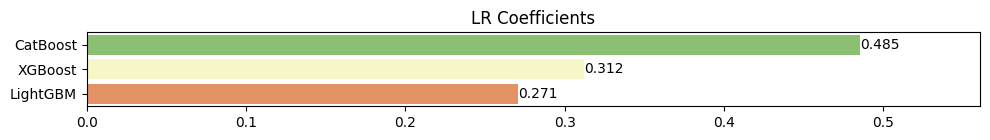

In [45]:
plot_weights(lr_coeffs, 'LR Coefficients')

## Results

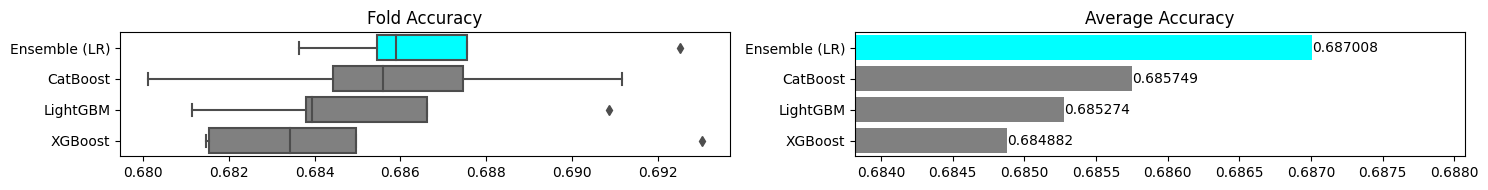

In [46]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.5))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', color='grey')
axs[0].set_title('Fold Accuracy')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color='grey')
axs[1].set_title('Average Accuracy')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = 'cyan' if 'ensemble' in model.lower() else 'grey'
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()

# Submission

In [47]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = (lr_test_pred_probs > 0.5).astype(int)
sub[CFG.target] = sub[CFG.target].map({0: "model_a", 1: "model_b"})
sub.to_csv('submission.csv', index=False)
sub.head()

,id,winner
0,327228,model_b
1,1139415,model_a
2,1235630,model_a
